### 1. Set Up Environment

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import _keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
import zipfile
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.10.0


### 2. Set up GPU running for Tensorflow

In [68]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


In [70]:
# unzip dataset file
path_to_zip_file = './Furniture_Data.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')
    zip_ref.close()

### 3. Handle Base Furniture Dataset
#### 3.1. Data Preparation

In [5]:
# Define the root directory where your categorical folders are located
base_data_dir = "./Furniture_Data"

# Function to get all folder names within a directory
def get_furiture_categories(directory):
    folders = []
    for item in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, item)):
            folders.append(item)
    return folders

# Function to get the number of categorical folders and the number of folders within each categorical folder
def get_category_info(root_dir):
    categorical_folders = get_furiture_categories(root_dir)
    num_categorical_folders = len(categorical_folders)
    folder_info = {}
    for cat_folder in categorical_folders:
        cat_folder_path = os.path.join(root_dir, cat_folder)
        folders_in_cat = get_furiture_categories(cat_folder_path)
        num_folders_in_cat = len(folders_in_cat)
        folder_info[cat_folder] = {
            "num_folders": num_folders_in_cat,
            "folders": folders_in_cat
        }
    return num_categorical_folders, folder_info

In [6]:
# Get the number of categorical folders and the number of folders within each categorical folder
num_categorical_folders, folder_info = get_category_info(base_data_dir)
print("Number of categorical folders:", num_categorical_folders)
print("Folder info within each categorical folder:")
for cat_folder, info in folder_info.items():
    print(f" - {cat_folder}: {info['num_folders']} folders")
    print(f"   {info['folders']}")

Number of categorical folders: 2
Folder info within each categorical folder:
 - beds: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - chairs: 15 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional']


In [7]:
# Function to get the image paths as a dictionary
def get_image_paths_dict(root_dir):
    image_paths_dict = {}
    for cat_folder, info in folder_info.items():
        cat_image_paths = {}
        for fur_type in info['folders']:
            dir_link = os.path.join(base_data_dir, cat_folder, fur_type)
            image_paths = [os.path.join(dir_link, img_path) for img_path in os.listdir(dir_link)]
            cat_image_paths[fur_type] = image_paths
        image_paths_dict[cat_folder] = cat_image_paths
    return image_paths_dict

# Get the image paths as a dictionary
image_paths_dict = get_image_paths_dict(base_data_dir)

# Print example paths from the dictionary
for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        print(f"Category: {cat_folder}, Fur type: {fur_type}")
        print("Example paths:")
        for path in paths[:3]:  # print first 3 paths for each fur type
            print(path)
        print("...")



Category: beds, Fur type: Asian
Example paths:
./Furniture_Data\beds\Asian\19726asian-daybeds.jpg
./Furniture_Data\beds\Asian\20027asian-canopy-beds.jpg
./Furniture_Data\beds\Asian\20109asian-panel-beds.jpg
...
Category: beds, Fur type: Beach
Example paths:
./Furniture_Data\beds\Beach\24547beach-style-nightstands-and-bedside-tables.jpg
./Furniture_Data\beds\Beach\2832beach-style-canopy-beds.jpg
./Furniture_Data\beds\Beach\3858beach-style-panel-beds.jpg
...
Category: beds, Fur type: Contemporary
Example paths:
./Furniture_Data\beds\Contemporary\1001contemporary-platform-beds.jpg
./Furniture_Data\beds\Contemporary\1002contemporary-bunk-beds.jpg
./Furniture_Data\beds\Contemporary\1003contemporary-adjustable-beds.jpg
...
Category: beds, Fur type: Craftsman
Example paths:
./Furniture_Data\beds\Craftsman\2638craftsman-panel-beds.jpg
./Furniture_Data\beds\Craftsman\2671craftsman-platform-beds.jpg
./Furniture_Data\beds\Craftsman\27972craftsman-daybeds.jpg
...
Category: beds, Fur type: Eclectic

In [17]:
# Convert the dictionary of image paths into a DataFrame
df_list = []

for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        for path in paths:
            df_list.append({
                "Furniture_Category": cat_folder,
                "Furniture_Type": fur_type,
                "Image_Path": path
            })

# Create DataFrame from the list of dictionaries
furniture_df = pd.DataFrame(df_list)

# Print the DataFrame
print(furniture_df.head())

  Furniture_Category Furniture_Type  \
0               beds          Asian   
1               beds          Asian   
2               beds          Asian   
3               beds          Asian   
4               beds          Asian   

                                          Image_Path  
0  ./Furniture_Data\beds\Asian\19726asian-daybeds...  
1  ./Furniture_Data\beds\Asian\20027asian-canopy-...  
2  ./Furniture_Data\beds\Asian\20109asian-panel-b...  
3  ./Furniture_Data\beds\Asian\20508asian-platfor...  
4  ./Furniture_Data\beds\Asian\20750asian-comfort...  


#### 3.2. Exploration Data Analysis (EDA)

In [18]:
furniture_df.shape

(24661, 3)

In [22]:
furniture_df['Furniture_Category'].value_counts()

Furniture_Category
chairs    18083
beds       6578
Name: count, dtype: int64

<Axes: xlabel='Furniture_Category'>

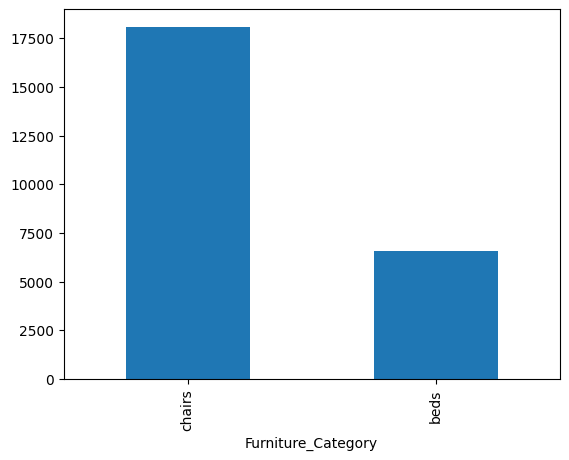

In [23]:
furniture_df['Furniture_Category'].value_counts().plot.bar()

In [24]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts()

Furniture_Category  Furniture_Type
beds                Contemporary      1953
                    Transitional      1719
                    Traditional       1397
                    Modern             380
                    Rustic             239
                    Craftsman          188
                    Midcentury         130
                    Farmhouse           91
                    Victorian           83
                    Mediterranean       75
                    Industrial          61
                    Tropical            55
                    Asian               52
                    Beach               51
                    Southwestern        49
                    Scandinavian        33
                    Eclectic            22
chairs              Contemporary      4608
                    Traditional       3956
                    Midcentury        3585
                    Modern            1788
                    Transitional      1192
                   

<Axes: xlabel='Furniture_Category,Furniture_Type'>

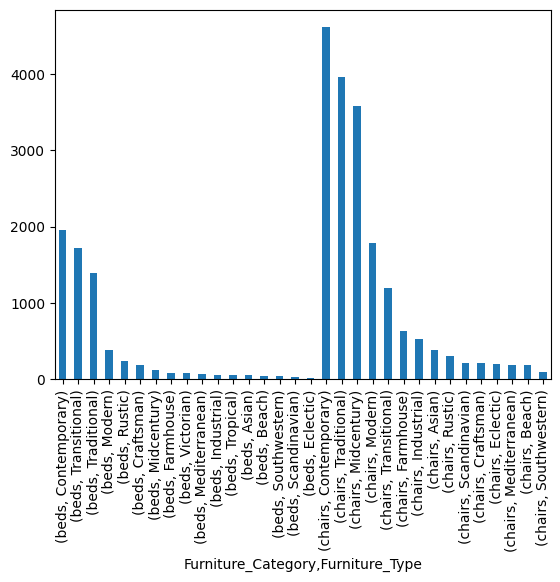

In [25]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts().plot.bar()

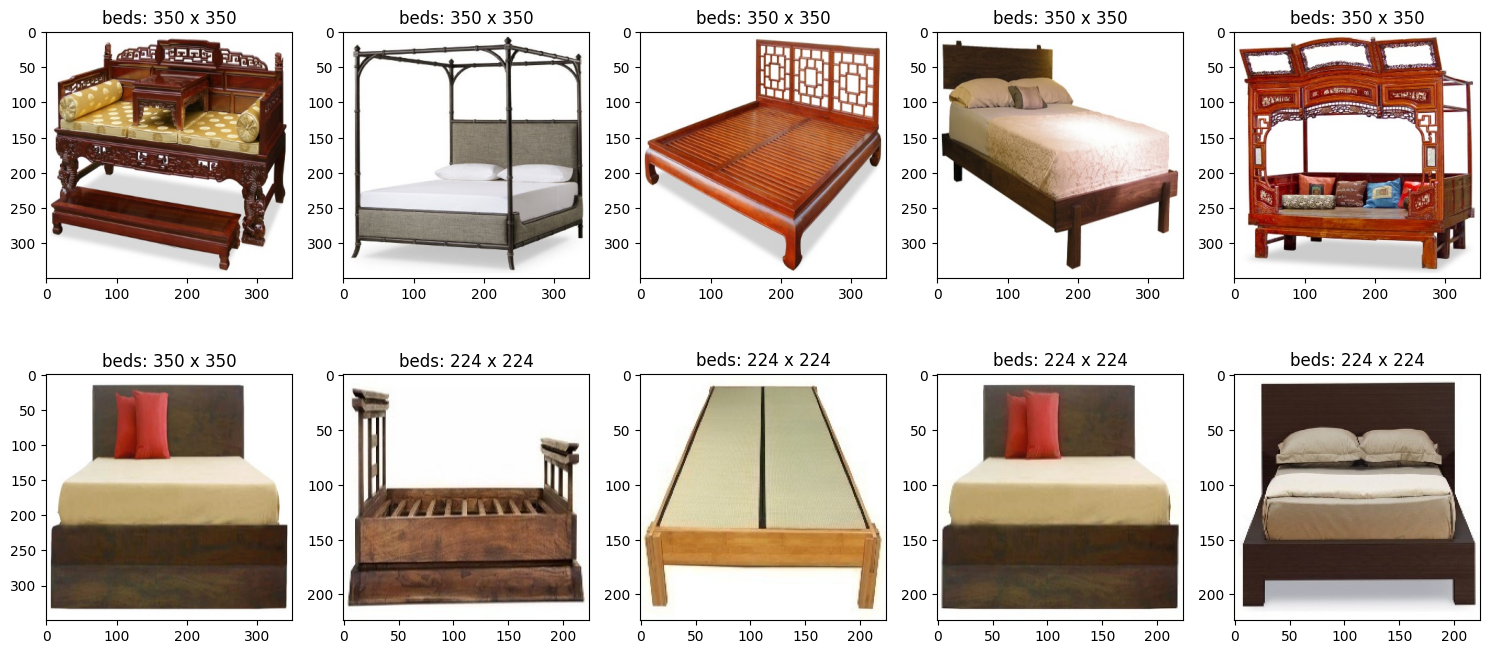

In [26]:
# Check image for image overview (contain name and size of flower images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(furniture_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(furniture_df.loc[i, "Furniture_Category"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

### 4. Handle additional data from crawling website
#### 4.1 Data Preparation

#### 4.2. Exploration Data Analysis (EDA)

### 5. Group 2 dataset into 1

### 6. Split data into train and test set and prepare for data augmentation and normalization

In [34]:
dev, test = train_test_split(furniture_df,train_size=0.85, shuffle=True, random_state=333)

In [35]:
dev.shape, test.shape

((20961, 3), (3700, 3))

In [49]:
#defined
BATCH_SIZE = 32

IMG_WIDTH  = 224
IMG_HEIGHT = 224

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=180,
                                    # width_shift_range=0.05,
                                    # height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [50]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 17817 validated image filenames belonging to 2 classes.
Found 3144 validated image filenames belonging to 2 classes.
Found 3700 validated image filenames.


In [51]:
print(train_ds.class_indices)

{'beds': 0, 'chairs': 1}


(32, 224, 224, 3)
(32, 2)
Label:  [0. 1.]


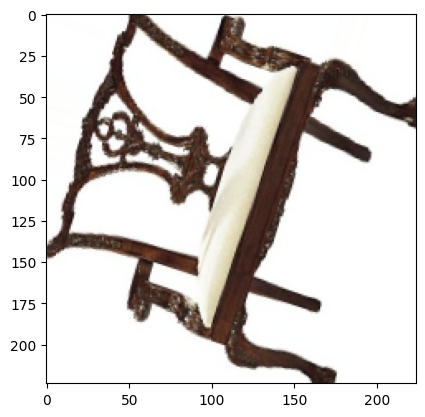

Label:  [1. 0.]


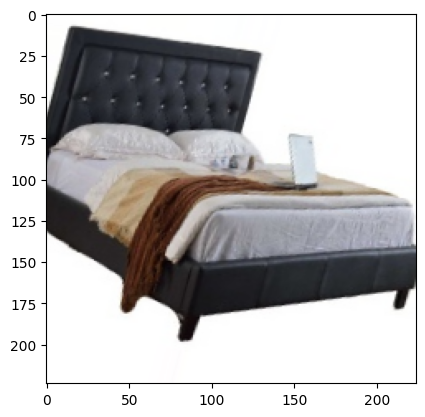

Label:  [1. 0.]


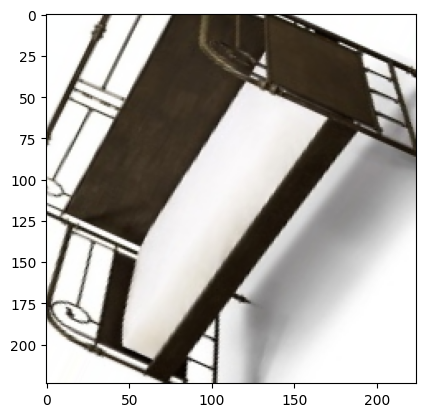

In [52]:
# Check image after data augmentation and normalization
batchX, batchY = train_ds.next()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

Model Construction Building

In [58]:
# model = Sequential([
#     Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    
#     Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

#     Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

#     Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

#     Flatten(),
#     Dropout(0.5),
#     Dense(units=1024, activation='relu'),
#     Dropout(0.5),
#     Dense(units=512, activation='relu'),

#     Dense(2, activation='softmax')
# ])

# model.summary()

In [64]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Flatten(),
    Dropout(0.5),
    Dense(units=256, activation='relu'),

    Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 28, 28, 16)      

In [65]:
# Fine tuning for Adam and Early Stopping function
optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

# Test with Epoch of 20
history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])

Epoch 1/10
557/557 [==============================] - 483s 863ms/step - loss: 0.5467 - accuracy: 0.7447 - val_loss: 0.5292 - val_accuracy: 0.7634
Epoch 2/10
557/557 [==============================] - 495s 888ms/step - loss: 0.4587 - accuracy: 0.7923 - val_loss: 0.4253 - val_accuracy: 0.8149
Epoch 3/10
557/557 [==============================] - 501s 899ms/step - loss: 0.4129 - accuracy: 0.8103 - val_loss: 0.3883 - val_accuracy: 0.8139
Epoch 4/10
557/557 [==============================] - 645s 1s/step - loss: 0.3700 - accuracy: 0.8297 - val_loss: 0.3163 - val_accuracy: 0.8645
Epoch 5/10
208/557 [==========>...................] - ETA: 4:34 - loss: 0.3399 - accuracy: 0.8467

KeyboardInterrupt: 